# Clustering Neighborhoods for Relocation
### IBM Data Science Capstone Project
by Albert Olszewski


## Table of Contents
* [Introduction / Business Problem](#introduction)
* [Data](#data)
* [Clustering the Neighborhoods](#clustering)
* [Mapping the Results](#mapping)
* [Results](#results)
* [Conclusion](#conclusion)

## Introduction / Business Problem <a name="introduction"></a>
&emsp; According to USA Today, the average person in the United States moves around 11 times in their lifetime.  A person may have to move for family or a job opportunity. Relocation is especially prominent for large tech and consulting firms that have locations in large cities.  Sometimes relocation has to be done without a prior visit or enough time to research neighborhoods and can result in someone moving to a neighborhood lacking wanted amenities. If a given person has found a neighborhood in their current city that has what they need to be comfortable, it would be nice to find a similar neighborhood in the city that they are moving to. This neighborhood would have similar amenities such as parks, schools, restaurants, and businesses. 
<br>
&emsp; In this project, we will be using machine learning to group like neighborhoods in New York City, Chicago, and Toronto in order that persons moving between them can find the most familiar and comfortable living situation possible. 

## Data  <a name="data"></a>
&emsp; Neighborhood data used in this project will be obtained using the Foursquare API. We will be collecting the top 10 neighborhood attributes from each neighborhoods. Listed neighborhoods will be scraped off of tables on a variety of wikipedia pages. All of this data will be merged and collected into a single data frame using the pandas library in Python.
<br>
<br>
Chicago Neighborhoods: https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago
<br>Toronto Neighborhoods: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
<br>New York Neighborhoods: https://geo.nyu.edu/catalog/nyu_2451_34572


&emsp;The latitude and longitude data for each neighborhood can be found using the geocoder package in python.  This package pulls latitude and longitude coordinates from Google. Documentation for this package can be found at https://geocoder.readthedocs.io 
Because this package has been known to be inconsistent at being able to gather data, some cities may have to have lat long entered via csv file.


Toronto Nieghborhoods GeoLoc: Geospatial_Coordinates.csv


In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import csv
import json
from geopy.geocoders import Nominatim

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
print("Packages Installed...")

Packages Installed...


### Toronto ###
&emsp;The neighborhoods are tabulated on wikipedia, so the names and boroughs will be scraped off of the link in the above section.  There was some issues with geocoders for getting the latitude and longitude info, so we will be loading it in from an attached CSV document.

In [3]:

# Toronto

source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(source, 'lxml')

postcodes = []
boroughs = []
neighborhoods = []
districts = []

for district in soup.find('table').find_all('tr'):
    try:
        postcode = district.find_all('td')[0].text
        borough = district.find_all('td')[1].text
        neighborhood = district.find_all('td')[2].text
        neighborhood = neighborhood.replace("\n","")
    except Exception as e:
        postcode = None
        borough = None
        neighborhood = None
    # compile data into a list
    districts.append([postcode,borough,neighborhood])


# get rid of postal codes not assigned to a borough
assigned_districts = []
for i in range(1,len(districts)):
    if districts[i][1]!='Not assigned':
        assigned_districts.append(districts[i])

# assign borough as neighborhoods for unassigned neighborhoods
for j in range(0,len(assigned_districts)):
    if assigned_districts[j][2] == 'Not assigned':
        assigned_districts[j][2] = assigned_districts[j][1]
        
# creating dataframe
df = pd.DataFrame(data = assigned_districts, columns = ['Postal Code','Borough','Neighborhood'])
# joining neighborhoods with same postalcode
df = df.groupby(['Postal Code','Borough'])['Neighborhood'].apply(lambda x: ','.join(x.astype(str))).reset_index()

latlong = pd.read_csv('Geospatial_Coordinates.csv')
# join dataframes
df_torontoinfo = pd.merge(df,latlong, how = 'inner')
# remove Postal Code becuase we don't need it anymore
df_torontoinfo = df_torontoinfo.drop(['Postal Code'], axis = 1)
df_torontoinfo.head()

,Borough,Neighborhood,Latitude,Longitude
0,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,Scarborough,Woburn,43.770992,-79.216917
4,Scarborough,Cedarbrae,43.773136,-79.239476


### Chicago ###
&emsp;Neighborhood names and community areas of Chicago are tabulated on a wikipedia page found in the above section.  The "community areas" are technically not "boroughs" but will be labeled as such in order to maintain consistency from city to city. The latitude and longitude values for each neighborhood will be found using the geocoders package.  If a neighborhood does not have available latitude and longitude data, it will be assigned the latitude and longitude values of their community area centers.

In [4]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago').text
soup = BeautifulSoup(source, 'lxml')

boroughs = []
neighborhoods = []
districts = []
i=0
#district = soup.find('table').find_all('tr')
for district in soup.find('table').find_all('tr'):
    try:
        neighborhood = district.find_all('td')[0].text
        neighborhood = neighborhood.replace("\n","")
        borough = district.find_all('td')[1].text
        borough = borough.replace("\n","")
        
    except Exception as e: 
        neighborhood = None
        borough = None
    districts.append([borough,neighborhood])

# get rid of blank header
del districts[0]

In [5]:
# get lat and long data for each neighborhood
latlongs = []
geolocator = Nominatim()
for bor, neigh in districts:
    # if the lat long for a neighborhood throws an error, use the borough
    try:
        location = geolocator.geocode("{}, Chicago, IL".format(neigh))
        latlongs.append([bor,neigh,location.latitude,location.longitude])
    except Exception as e:
        # for neighborhoods that use two community areas use the first
        bor = bor.split(',')[0]
        location = geolocator.geocode("{}, Chicago, IL".format(bor))
        latlongs.append([bor,neigh,location.latitude,location.longitude])        


/Users/albertolszewski/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
# create dataframe 
df_chicagoinfo = pd.DataFrame(data = latlongs, columns = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'])
df_chicagoinfo.head()

,Borough,Neighborhood,Latitude,Longitude
0,Albany Park,Albany Park,41.971937,-87.716174
1,Riverdale,Altgeld Gardens,41.654864,-87.600446
2,Edgewater,Andersonville,41.977139,-87.669273
3,Archer Heights,Archer Heights,41.811422,-87.726165
4,Armour Square,Armour Square,41.840033,-87.633107


### New York City ###
&emsp;The a '.json' file is available for the New York City Data, so the procedure is a little different for obtaining the neighborhoods and their locations.

In [7]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
df_newyorkinfo = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    df_newyorkinfo = df_newyorkinfo.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
df_newyorkinfo.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [16]:
# add city into each data frame
df_torontoinfo['City'] = 'Toronto'
df_chicagoinfo['City'] = 'Chicago'
df_newyorkinfo['City'] = 'New York'

# combine data frames into one
df_neighborhoodinfo = []
df_neighborhoodinfo = pd.concat([df_torontoinfo,df_chicagoinfo,df_newyorkinfo], ignore_index = True)
df_neighborhoodinfo = df_neighborhoodinfo.reset_index()
df_neighborhoodinfo.shape

(655, 6)

### Foursquare ###
&emsp;Now that we have data frames of each city with borough, neighborhood, latitude, and longitude we can start to request data from FourSquare about what each neighborhood has to offer.  Foursquare has made developer tools that allow us to input a location and recieve rich information such as nearby restaurants, parks and recreation, schools, and businesses.  You can obtain reviews, websites, and more of these places.  For the purpose of this project, we will only be tracking the types of amenities and the frequency of them for future clustering.

In [11]:
#Define the credentials needed for Foursquare API

CLIENT_ID = 'JFMMIPVEDBJHMKDINLMG5MU2Y45JMQA3E35JD14HUR5VCUEJ' # your Foursquare ID
CLIENT_SECRET = 'AYFWYZTKALQF5Q3540IKE5JDMCVDU0OW3LJEW5ZQ24THHMFQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JFMMIPVEDBJHMKDINLMG5MU2Y45JMQA3E35JD14HUR5VCUEJ
CLIENT_SECRET:AYFWYZTKALQF5Q3540IKE5JDMCVDU0OW3LJEW5ZQ24THHMFQ


In [12]:
# Creates a function that will take neighborhood name, latitude, and longitude data as inputs and output venues

radius = 500
LIMIT = 100


def getNearbyVenues(names, latitudes, longitudes, radius=500):
    i = 0
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(i, name)
        i = i +1
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Be careful when running the following function.  We are running on the free version of the Foursquare Developer API. We only get 950 calls a day.  There are 655 neighborhoods in this city, so the function can only be completed once a day.

In [13]:
neighborhood_venues = getNearbyVenues(names=df_neighborhoodinfo['Neighborhood'],
                                   latitudes=df_neighborhoodinfo['Latitude'],
                                   longitudes=df_neighborhoodinfo['Longitude']
                                  )


0 Rouge,Malvern
1 Highland Creek,Rouge Hill,Port Union
2 Guildwood,Morningside,West Hill
3 Woburn
4 Cedarbrae
5 Scarborough Village
6 East Birchmount Park,Ionview,Kennedy Park
7 Clairlea,Golden Mile,Oakridge
8 Cliffcrest,Cliffside,Scarborough Village West
9 Birch Cliff,Cliffside West
10 Dorset Park,Scarborough Town Centre,Wexford Heights
11 Maryvale,Wexford
12 Agincourt
13 Clarks Corners,Sullivan,Tam O'Shanter
14 Agincourt North,L'Amoreaux East,Milliken,Steeles East
15 L'Amoreaux West
16 Upper Rouge
17 Hillcrest Village
18 Fairview,Henry Farm,Oriole
19 Bayview Village
20 Silver Hills,York Mills
21 Newtonbrook,Willowdale
22 Willowdale South
23 York Mills West
24 Willowdale West
25 Parkwoods
26 Don Mills North
27 Flemingdon Park,Don Mills South
28 Bathurst Manor,Downsview North,Wilson Heights
29 Northwood Park,York University
30 CFB Toronto,Downsview East
31 Downsview West
32 Downsview Central
33 Downsview Northwest
34 Victoria Village
35 Woodbine Gardens,Parkview Hill
36 Woodbine Height

389 Castle Hill
390 Olinville
391 Pelham Gardens
392 Concourse
393 Unionport
394 Edenwald
395 Bay Ridge
396 Bensonhurst
397 Sunset Park
398 Greenpoint
399 Gravesend
400 Brighton Beach
401 Sheepshead Bay
402 Manhattan Terrace
403 Flatbush
404 Crown Heights
405 East Flatbush
406 Kensington
407 Windsor Terrace
408 Prospect Heights
409 Brownsville
410 Williamsburg
411 Bushwick
412 Bedford Stuyvesant
413 Brooklyn Heights
414 Cobble Hill
415 Carroll Gardens
416 Red Hook
417 Gowanus
418 Fort Greene
419 Park Slope
420 Cypress Hills
421 East New York
422 Starrett City
423 Canarsie
424 Flatlands
425 Mill Island
426 Manhattan Beach
427 Coney Island
428 Bath Beach
429 Borough Park
430 Dyker Heights
431 Gerritsen Beach
432 Marine Park
433 Clinton Hill
434 Sea Gate
435 Downtown
436 Boerum Hill
437 Prospect Lefferts Gardens
438 Ocean Hill
439 City Line
440 Bergen Beach
441 Midwood
442 Prospect Park South
443 Georgetown
444 East Williamsburg
445 North Side
446 South Side
447 Ocean Parkway
448 Fort Ham

In [18]:
neighborhood_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge,Malvern",43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop
2,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Chris Effects Painting,43.784343,-79.163742,Construction & Landscaping
3,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
4,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place


### Preprocessing ###
In order to perform clustering analysis on the data we have collected we must prepare it using one hot encoding.

In [19]:
# one hot encoding
neighborhood_onehot = pd.get_dummies(neighborhood_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
neighborhood_onehot['Neighborhood'] = neighborhood_venues['Neighborhood'] 
first_index = neighborhood_onehot.columns.get_loc('Neighborhood')
fixed_columns = [neighborhood_onehot.columns[first_index]] + list(neighborhood_onehot.columns[:first_index]) + list(neighborhood_onehot.columns[first_index+1:]) 
neighborhood_onehot = neighborhood_onehot[fixed_columns]

neighborhood_grouped = neighborhood_onehot.groupby('Neighborhood').mean().reset_index()
neighborhood_grouped

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,...,Waste Facility,Watch Shop,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide,King,Richmond",0.000000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.01000,0.000000,0.000000,0.000000,0.000000
1,Agincourt,0.000000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0.000000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
3,Albany Park,0.000000,0.0625,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
4,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0.000000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
5,"Alderwood,Long Branch",0.000000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
6,Allerton,0.000000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
7,Altgeld Gardens,0.000000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
8,Andersonville,0.000000,0.0000,0.0125,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.012500,0.00000,0.012500,0.000000,0.000000,0.000000
9,Annadale,0.000000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [21]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhood_venues_sorted = pd.DataFrame(columns=columns)
neighborhood_venues_sorted['Neighborhood'] = neighborhood_grouped['Neighborhood']

for ind in np.arange(neighborhood_grouped.shape[0]):
    neighborhood_venues_sorted.iloc[ind, 1:] = return_most_common_venues(neighborhood_grouped.iloc[ind, :], num_top_venues)

neighborhood_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Café,Coffee Shop,Bar,Steakhouse,American Restaurant,Burger Joint,Restaurant,Gym,Hotel,Bakery
1,Agincourt,Chinese Restaurant,Breakfast Spot,Lounge,Sandwich Place,Yoga Studio,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Park,Asian Restaurant,Playground,Yoga Studio,Farm,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space
3,Albany Park,Sandwich Place,Hookah Bar,Karaoke Bar,Grocery Store,Bakery,Cocktail Bar,Mobile Phone Shop,Pizza Place,Diner,Korean Restaurant
4,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Grocery Store,Pizza Place,Sandwich Place,Fried Chicken Joint,Beer Store,Pharmacy,Liquor Store,Video Store,Coffee Shop,Fast Food Restaurant


## Clustering the Neighborhoods <a name="clustering"></a>
&emsp;In this project, we want to cluster neighborhoods together based on like characteristics.  We want to use a clustering machine learning technique because we don't know exactly what type of categories these neighborhoods are going to be.  We chose to use K-Means algorithms because it is a simple algorithm that performs very well.  The data set we are analyzing is large enought that we need a clustering algorithm that is efficient, but it is not so large that we need to use DBSCAN. 

An ideal value of K will be chosen using the elbow method.

In [22]:
# remove neighborhood as an trait to cluster on
neighborhood_grouped_clustering = neighborhood_grouped.drop('Neighborhood', 1)


# loop through values of k and choose optimal number of groups based on elbow method
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, random_state = 0).fit(neighborhood_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    

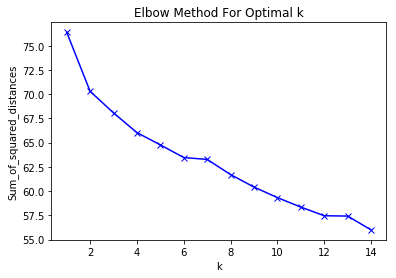

In [23]:
# plot k vs sum of squared distances
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The "Sum of Squared Distances" will decrease as long as K increases.  We choose the first elbow point which looks like it is at k = 6.

In [24]:
# set number of clusters
kclusters = 6


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(neighborhood_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]


array([4, 0, 1, 0, 0, 0, 0, 2, 4, 0], dtype=int32)

In [26]:
# add clustering labels. comment out next line if running for the first time.
# neighborhood_venues_sorted.drop('Cluster Labels', axis = 1, inplace = True)
neighborhood_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

neighborhood_merged = df_neighborhoodinfo

# merge neighborhood_grouped with neighborhood_data to add latitude/longitude for each neighborhood
neighborhood_merged = neighborhood_merged.join(neighborhood_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# drop rows with NA.  These rows are likely neighborhoods that did not have any data on Foursquare
neighborhood_merged = neighborhood_merged.dropna()
neighborhood_merged['Cluster Labels'] = neighborhood_merged['Cluster Labels'].astype('int64')
neighborhood_merged.head()

,index,Borough,Neighborhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Scarborough,"Rouge,Malvern",43.806686,-79.194353,Toronto,0,Fast Food Restaurant,Print Shop,Farmers Market,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit
1,1,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Toronto,4,Construction & Landscaping,Bar,Yoga Studio,Fast Food Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit
2,2,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Toronto,0,Rental Car Location,Pizza Place,Spa,Mexican Restaurant,Tech Startup,Medical Center,Electronics Store,Breakfast Spot,Intersection,Currency Exchange
3,3,Scarborough,Woburn,43.770992,-79.216917,Toronto,4,Coffee Shop,Convenience Store,Korean Restaurant,Yoga Studio,Falafel Restaurant,Factory,Fabric Shop,Eye Doctor,Exhibit,Event Space
4,4,Scarborough,Cedarbrae,43.773136,-79.239476,Toronto,0,Bank,Lounge,Caribbean Restaurant,Athletics & Sports,Thai Restaurant,Hakka Restaurant,Fried Chicken Joint,Bakery,Ethiopian Restaurant,Event Service


Now that we have ran the clustering algorithms on all of the neighborhoods together, we must now seperate the cities again to plot and discuss them. For each data frame we want the city, borough, neighborhood, latitude, longitude, and cluster number.

In [27]:
# get indices of cities in data frame
torindex = neighborhood_merged.index[neighborhood_merged['City'] == 'Toronto'].tolist()
chicindex = neighborhood_merged.index[neighborhood_merged['City'] == 'Chicago'].tolist()
newyindex = neighborhood_merged.index[neighborhood_merged['City'] == 'New York'].tolist()

# create new data frames with indices
toronto_merged = neighborhood_merged.loc[torindex]
chicago_merged = neighborhood_merged.loc[chicindex]
newyork_merged = neighborhood_merged.loc[newyindex]

## Mapping Results <a name="mapping"></a>
Now let us map the neighborhoods in the city they belong to with markers signifying what cluster they are in.

In [28]:
# create map of Toronto using latitude and longitude values
latitude = 43.6532
longitude = -79.3832
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]



# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_toronto)
       
map_toronto

In [34]:
# create map of Chicago using latitude and longitude values
latitude = 41.8781
longitude = -87.6298
map_chicago = folium.Map(location=[latitude, longitude], zoom_start=9.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_merged['Latitude'], chicago_merged['Longitude'], chicago_merged['Neighborhood'], chicago_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_chicago)
       
map_chicago

In [35]:
# create map of New York City using latitude and longitude values
latitude = 40.7128 
longitude = -74.0060
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(newyork_merged['Latitude'], newyork_merged['Longitude'], newyork_merged['Neighborhood'], newyork_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_newyork)
       
map_newyork

### Legend
Cluster 0 : red 
<br/>
Cluster 1 : purple
<br/>
Cluster 2 : blue
<br/>
Cluster 3 : cyan
<br/>
Cluster 4 : light green
<br/>
Cluster 5 : orange

## Results <a name="results"></a>
### Examine Clusters <a name="examine"></a>
Now that we have clustered the data and mapped it, we should take a deaper look at what the clusters contain in order to describe it to the client.

In [153]:
# Cluster 0
# grab cluster 0
cluster_zero = neighborhood_merged.loc[neighborhood_merged['Cluster Labels'] == 0, neighborhood_merged.columns[[2] + list(range(5, neighborhood_merged.shape[1]))]]
# get the value counts of the 1st, 2nd, and 3rd most common venues of the cluster.
cluster_zero['1st Most Common Venue'].append(cluster_zero['2nd Most Common Venue']).append(cluster_zero['3rd Most Common Venue']).value_counts()[:5]

Coffee Shop           96
Sandwich Place        62
Bar                   50
Italian Restaurant    46
Pizza Place           33
dtype: int64

In [172]:
# check how many neighborhoods are in this cluster
cluster_zero.shape

(381, 13)

&emsp;Neighborhoods that fall into Cluster 0 are heavily populated with coffee shops, bars, and italian restaurants.  If we look at the maps with the clusters plotted on them, it looks like these locations are located closer to the downtown areas of each city.  This cluster is likely higher end living and located close to businesses. Someone who live in a Cluster 0 of one neighborhood is likely to live in a busy part of the city that is heavily populated.  Cluster 0 is also the largest cluster with 381 neighborhoods in it.

In [154]:
# Cluster 1
cluster_one = neighborhood_merged.loc[neighborhood_merged['Cluster Labels'] == 1, neighborhood_merged.columns[[2] + list(range(5, neighborhood_merged.shape[1]))]]
cluster_one['1st Most Common Venue'].append(cluster_one['2nd Most Common Venue']).append(cluster_one['3rd Most Common Venue']).value_counts()[:5]

Pizza Place           86
Deli / Bodega         49
Chinese Restaurant    32
Grocery Store         23
Pharmacy              21
dtype: int64

In [173]:
cluster_one.shape

(199, 13)

&emsp;Neighborhoods that fall into Cluster 1 are heavily populated with pizza places, bodegas, chinese food, and pharmacies.  The neighborhoods are located outside of the city centers or downtown areas.  Due to the amenities available and the location of these neighborhoods, they are likely a little more affordable and residential than neighborhoods in Cluster 0. This cluster is the 2nd largest with 199 neighborhoods.

In [155]:
# Cluster 2
cluster_two = neighborhood_merged.loc[neighborhood_merged['Cluster Labels'] == 2, neighborhood_merged.columns[[2] + list(range(5, neighborhood_merged.shape[1]))]]
cluster_two['1st Most Common Venue'].append(cluster_two['2nd Most Common Venue']).append(cluster_two['3rd Most Common Venue']).value_counts()[:5]

Egyptian Restaurant    2
Baseball Field         2
Yoga Studio            2
dtype: int64

In [174]:
cluster_two.shape

(2, 13)

&emsp;Cluster 2 is a very small cluster with only 2 neighborhoods in it.  It is a very specific type of neighborhood containing Egyptian restaurants, baseball fields, and yoga studios as the most common venues.  The only neighborhoods in this cluster are in Toronto, so if someone is looking for a neighborhood similar to these two neighborhoods they would have to look at another cluster for Chicago or New York City.

In [156]:
# Cluster 3
cluster_three = neighborhood_merged.loc[neighborhood_merged['Cluster Labels'] == 3, neighborhood_merged.columns[[2] + list(range(5, neighborhood_merged.shape[1]))]]
cluster_three['1st Most Common Venue'].append(cluster_three['2nd Most Common Venue']).append(cluster_three['3rd Most Common Venue']).value_counts()[:5]

Park                8
Yoga Studio         8
Football Stadium    4
Campground          2
Grocery Store       1
dtype: int64

In [175]:
cluster_three.shape

(8, 13)

&emsp;Cluster 3 is also a smaller cluster with only 8 neighborhoods in it; however, it does have neighborhoods in all 3 cities.  These neighborhoods are heavily populated with parks, yoga studios, football staiums, and grocery stores.  This cluster is very similar to Cluster 2.  They both likely have a lot of schools and are good places to house families based off of their amenities. 

In [157]:
# Cluster 4
cluster_four = neighborhood_merged.loc[neighborhood_merged['Cluster Labels'] == 4, neighborhood_merged.columns[[2] + list(range(5, neighborhood_merged.shape[1]))]]
cluster_four['1st Most Common Venue'].append(cluster_four['2nd Most Common Venue']).append(cluster_four['3rd Most Common Venue']).value_counts()[:5]

Tennis Court                   3
Yoga Studio                    3
Playground                     3
Park                           1
Eastern European Restaurant    1
dtype: int64

In [176]:
cluster_four.shape

(4, 13)

&emsp;Cluster 4 only contains neighborhoods in Toronto and New York City.  There is only 4 total neighborhoods in this cluster.  The most popular venues in this neighborhood are tennis courts, yoga studios, playgrounds, and parks.  This neighborhood is also similar to Clusters 2 and 3 but might be more suitable for a young family (given that there are plenty of playgrounds.  

In [158]:
# Cluster 5
cluster_five = neighborhood_merged.loc[neighborhood_merged['Cluster Labels'] == 5, neighborhood_merged.columns[[2] + list(range(5, neighborhood_merged.shape[1]))]]
cluster_five['1st Most Common Venue'].append(cluster_five['2nd Most Common Venue']).append(cluster_five['3rd Most Common Venue']).value_counts()[:5]

Park                 51
Bus Station          10
Convenience Store     6
Food Truck            5
Intersection          4
dtype: int64

In [177]:
cluster_five.shape

(57, 13)

&emsp;Cluster 5 is heavily populated with parks, bus stations, convenience stores, food trucks, and intersections.  These neighborhoods offer more space, and would be very suitable for commuters because of the large availability of transportation options.  Cluster 5 contains 57 neighborhoods from all of the cities involved in this study.

## Conclusion <a name="conclusion"></a>

&emsp;In this project, we clustered neighborhoods together from Toronto, Chicago, and New York City based on the amenities they offered. Real time data was scraped off of the internet or gathered using the Foursquared Developer API.  A K-Means clustering algorithm was used to explore the collected data. This model will always be current when the code is run. This model can be useful for those who are relocating between these cities on short notice, but want to keep a similar neighborhood that they are comfortable living in. Brokers who work in real estate can use this data to provide better services to their customers. There are neighborhoods in every city that offer similar living situations for families, commuters, physically active workers, and deep city lovers. The data presented in this project gives rich information to those looking to move to either Toronto, Chicago, or New York City making it easier for them to make a comfortable decision on what neighborhood to live in.


### Future Works
&emsp;The information gathered in this project is very useful and insightful.  However, there is possibility for further development to make the material present more robust.  There are more major cities in North America that can be included in this study such as San Francisco, Seattle, or Houston. By including these cities, we can expand our reach of audience. It is completely possible that neighborhoods have different amenities than the ones listed on Foursquare. Data can be gathered from more sources to include housing price, square footage, surrounding cultures, religious organizations, and other aspects considered during moving. Overall, there are many ways to expand on this exciting insight and make it more useful to consumers.